# Korean Drama Recommendation System (2015–2023)

## Overview
Dalam proyek ini, dibangun dua sistem rekomendasi berdasarkan data Korean Drama 2015–2023 yang dikumpulkan dari [MyDramaList](https://mydramalist.com/) dan tersedia di [Kaggle](https://www.kaggle.com/datasets/chanoncharuchinda/korean-drama-2015-23-actor-and-reviewmydramalist). Sistem rekomendasi ini bertujuan untuk:

* Memberikan rekomendasi drama berdasarkan konten (content-based filtering)
* Memberikan rekomendasi personal berdasarkan penilaian pengguna lain (collaborative filtering)

### Problem Statements

1. Bagaimana mengidentifikasi kesamaan antar K-Drama berdasarkan elemen konten seperti sinopsis, sutradara, dan penulis naskah?
2. Bagaimana memberikan rekomendasi personal untuk pengguna berdasarkan preferensi dan ulasan pengguna lain?
3. Siapa figur kreatif (sutradara, penulis, aktor) yang paling sering muncul dalam drama-drama yang direkomendasikan kepada pengguna?

In [1]:
!pip install numpy==1.23.5
!pip install scikit-surprise --no-binary :all:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Data Understanding

Dataset yang digunakan dalam proyek ini diambil dari [Kaggle - Top 100 Korean Drama (MyDramaList)](https://www.kaggle.com/datasets/chanoncharuchinda/top-100-korean-drama-mydramalist), yang dibuat untuk keperluan edukasi dan eksplorasi data oleh penggemar K-Drama. Dataset ini menyatukan berbagai aspek dari dunia drama Korea berdasarkan data komunitas dari situs **MyDramaList.com**, sebuah platform populer untuk penggemar drama dan film Asia.

### Struktur Dataset

Dataset terdiri dari **empat file utama**:

* **`korean_drama.csv`**
  Berisi 1.752 entri drama Korea, lengkap dengan informasi seperti judul, tahun rilis, genre, penulis naskah, sutradara, durasi, sinopsis, rating konten, dan popularitas.

* **`recommendations.csv`**
  Berisi daftar rekomendasi antar drama. Informasi ini berasal dari sistem rekomendasi komunitas MyDramaList.

* **`review.csv`**
  Berisi 10.625 ulasan pengguna terhadap drama, mencakup penilaian terhadap cerita, akting, musik, nilai rewatch, serta skor keseluruhan.

* **`wiki_actor.csv`**
  Menyediakan data tentang aktor, termasuk nama, drama yang dibintangi, nama karakter, dan peran mereka (utama atau pendukung).

> **Catatan**: Data reviewer telah dianonimkan dengan ID pengguna yang dihasilkan untuk menjaga privasi.

> Tentang MyDramaList.com
MyDramaList adalah proyek berbasis komunitas yang memungkinkan pengguna membuat daftar tontonan, memberi rating, menulis ulasan, dan berbagi informasi tentang drama dan film Asia. Platform ini menjadi sumber utama data untuk proyek ini.

In [5]:
# Load data

drama_df = pd.read_csv("korean_drama.csv")
reviews_df = pd.read_csv("reviews.csv")
recommendations_df = pd.read_csv("recommendations.csv")
actors_df = pd.read_csv("wiki_actors.csv")

In [6]:
# Informasi data

drama_df.info()
reviews_df.info()
recommendations_df.info()
actors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   kdrama_id     1752 non-null   object 
 1   drama_name    1752 non-null   object 
 2   year          1752 non-null   int64  
 3   director      1036 non-null   object 
 4   screenwriter  959 non-null    object 
 5   country       1752 non-null   object 
 6   type          1752 non-null   object 
 7   tot_eps       1752 non-null   int64  
 8   duration      1728 non-null   float64
 9   start_dt      1752 non-null   object 
 10  end_dt        1752 non-null   object 
 11  aired_on      1520 non-null   object 
 12  org_net       1344 non-null   object 
 13  content_rt    1752 non-null   object 
 14  synopsis      1584 non-null   object 
 15  rank          1752 non-null   int64  
 16  pop           1752 non-null   int64  
dtypes: float64(1), int64(4), object(12)
memory usage: 232.8+ KB
<class 'pan

In [7]:
drama_df.head()

,kdrama_id,drama_name,year,director,screenwriter,country,type,tot_eps,duration,start_dt,end_dt,aired_on,org_net,content_rt,synopsis,rank,pop
0,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush,2023,['So Joon Moon'],NaN,South Korea,Drama,8,1500.0,"Aug 2, 2023","Aug 2, 2023",Wednesday,NaN,Not Yet Rated,Follow the story of acquaintances Ba Ram and H...,1484,2238
1,5ffcbeaa17114714af1959129984274c,D.P. Season 2,2023,NaN,['Kim Bo Tong'],South Korea,Drama,6,3000.0,"Jul 28, 2023","Jul 28, 2023",Friday,Netflix,15+ - Teens 15 or older,This unfolding story ensues when military dese...,164,1084
2,65075cb9c1a54be4a441cee6f16c9fdf,Shadow Detective Season 2,2023,['Han Dong Hwa'],"['Song Jung Woo', 'Hwang Seol Hun']",South Korea,Drama,8,3300.0,2023-07-05,2023-07-26,Wednesday,Disney+ Hulu,15+ - Teens 15 or older,Unfolds the ultimate counterattack of veteran ...,2443,6915
3,df0f0ac4b3ff4b15afa26f5a7a53a328,To Be Honest,2023,NaN,NaN,South Korea,Drama,3,600.0,2023-06-30,2023-07-14,Friday,NaN,Not Yet Rated,Don't you have those days where the whole univ...,49895,99999
4,04c1fe41948e464fb440001831d74d41,Celebrity,2023,['Kim Chul Gyu'],['Kim Yi Young'],South Korea,Drama,12,2700.0,"Jun 30, 2023","Jun 30, 2023",Friday,Netflix,18+ Restricted (violence & profanity),Fame. Money. Power. One young woman fights to ...,826,547


In [8]:
reviews_df.head()

,user_id,title,story_score,acting_cast_score,music_score,rewatch_value_score,overall_score,review_text,ep_watched,n_helpful
0,c8ffdab3f2a338eeb54b265598dbbb55,Sing My Crush,9.0,9.0,10.0,9.0,9.0,the Best Song from my Crush This will now ran...,8 of 8 episodes seen,23
1,c8ffdab3f2a338eeb54b265598dbbb55,Happy Merry Ending,5.0,7.0,9.0,4.0,6.5,I'm Happy and Merry That it Ended Quickly The ...,8 of 8 episodes seen,31
2,c8ffdab3f2a338eeb54b265598dbbb55,Duty After School: Part 2,4.0,9.0,3.0,1.0,4.0,This PART 2 Should Never Have Happened If you...,4 of 4 episodes seen,121
3,c8ffdab3f2a338eeb54b265598dbbb55,Our Dating Sim,9.0,9.5,9.0,9.0,9.0,I want to play this dating sim! I want to pla...,8 of 8 episodes seen,79
4,c8ffdab3f2a338eeb54b265598dbbb55,The Director Who Buys Me Dinner,7.5,8.5,7.0,6.0,7.0,"Half-Cooked, Dont Eat A hard pass, unless som...",10 of 10 episodes seen,66


In [9]:
actors_df.head()

,actor_id,actor_name,drama_name,character_name,role
0,96612cd9-183e-4530-9e0d-d85322e6ec4c,Jang Do Yoon,Sing My Crush,Han Ba Ram,Main Role
1,96612cd9-183e-4530-9e0d-d85322e6ec4c,Jang Do Yoon,Finland Papa,Toto / Seung Yoon,Support Role
2,96612cd9-183e-4530-9e0d-d85322e6ec4c,Jang Do Yoon,My Sweet Dear,Ye Jun,Support Role
3,96612cd9-183e-4530-9e0d-d85322e6ec4c,Jang Do Yoon,Lemon Car Video,Jang Do Yoon (Ep. 1),Main Role
4,b5f2eca0-6e6b-474d-88ad-46f4feaa0a8e,Son Hyun Woo,Sing My Crush,Im Han Tae,Main Role


**Insight**: proyek ini akan fokus menggunakan 3 dataframe saja; drama_df, reviews_df, dan actors_df karena item recommendations_df tidak begitu substansial.

# Univariate Exploratory Data Analysis

## drama_df

In [10]:
# Missing values
drama_df.isnull().sum()

,0
kdrama_id,0
drama_name,0
year,0
director,716
screenwriter,793
country,0
type,0
tot_eps,0
duration,24
start_dt,0


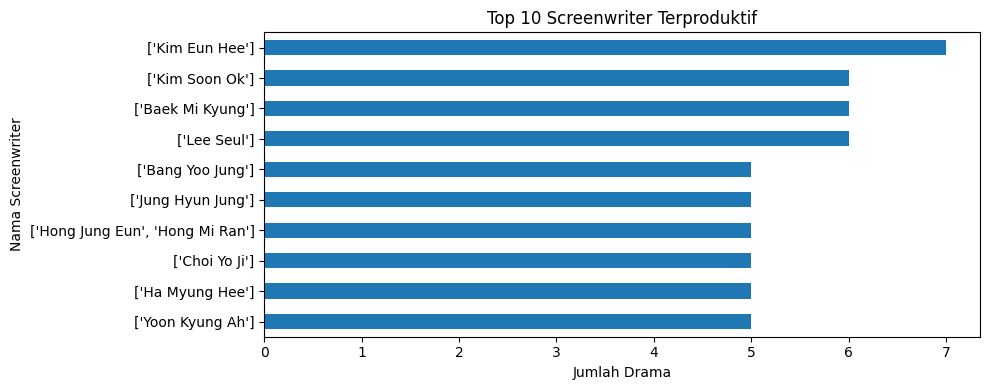

In [11]:
# Top 10 Screenwriter Terproduktif
plt.figure(figsize=(10, 4))
drama_df['screenwriter'].value_counts().head(10).plot(kind='barh')
plt.title('Top 10 Screenwriter Terproduktif')
plt.xlabel('Jumlah Drama')
plt.ylabel('Nama Screenwriter')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

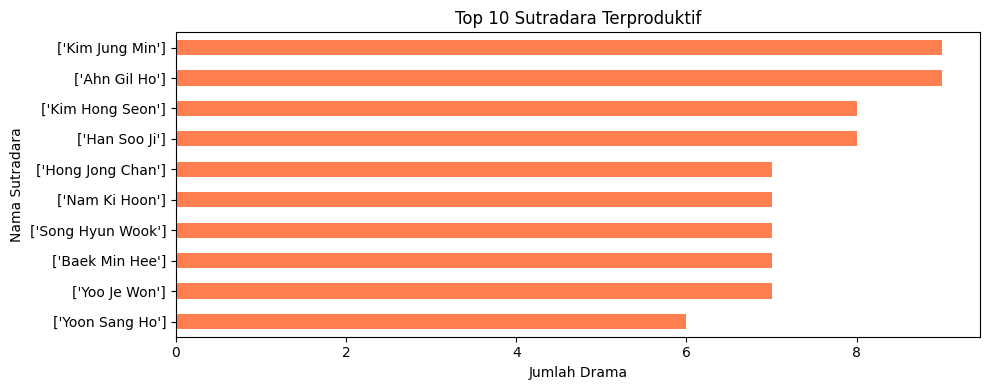

In [12]:
# Top 10 Sutradara Terproduktif
plt.figure(figsize=(10, 4))
drama_df['director'].value_counts().head(10).plot(kind='barh', color='coral')
plt.title('Top 10 Sutradara Terproduktif')
plt.xlabel('Jumlah Drama')
plt.ylabel('Nama Sutradara')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

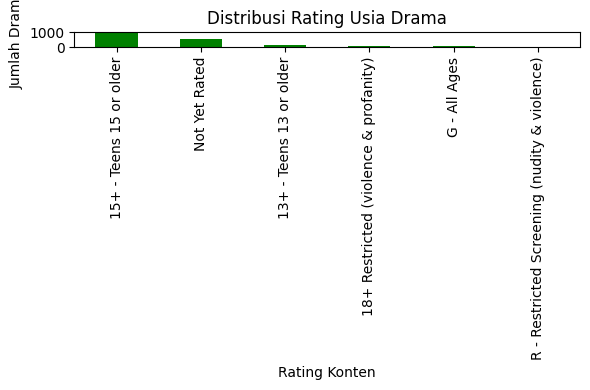

In [13]:
# Distribusi Rating Usia
plt.figure(figsize=(6, 4))
drama_df['content_rt'].value_counts().plot(kind='bar', color='green')
plt.title('Distribusi Rating Usia Drama')
plt.xlabel('Rating Konten')
plt.ylabel('Jumlah Drama')
plt.tight_layout()
plt.show()

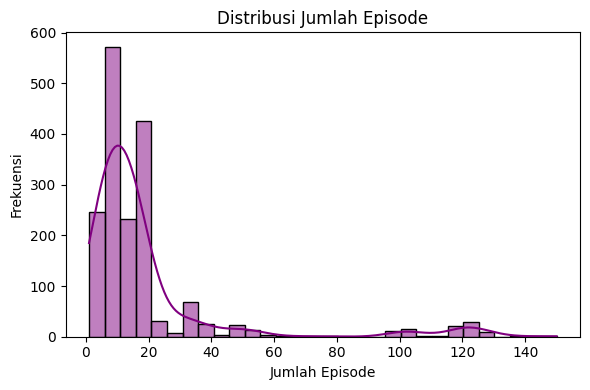

In [14]:
# Distribusi Jumlah Episode
plt.figure(figsize=(6, 4))
sns.histplot(drama_df['tot_eps'], bins=30, kde=True, color='purple')
plt.title('Distribusi Jumlah Episode')
plt.xlabel('Jumlah Episode')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

/tmp/ipython-input-15-494581755.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_aired_on.values, y=top_aired_on.index, palette='rocket')


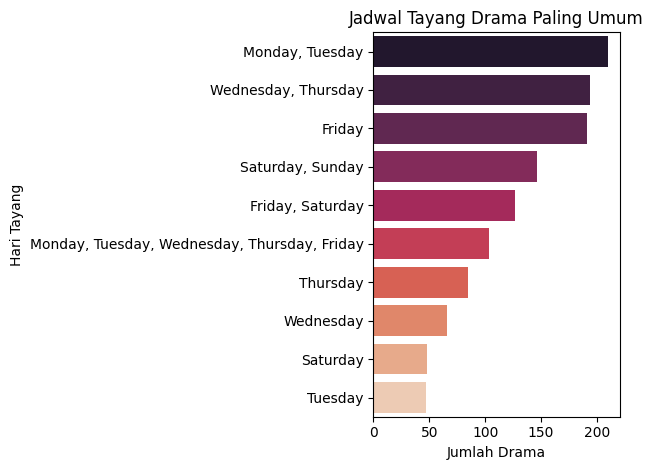

In [15]:
# Distribusi Hari Tayang
plt.figure()
top_aired_on = drama_df['aired_on'].dropna().value_counts().nlargest(10)
sns.barplot(x=top_aired_on.values, y=top_aired_on.index, palette='rocket')
plt.title('Jadwal Tayang Drama Paling Umum')
plt.xlabel('Jumlah Drama')
plt.ylabel('Hari Tayang')
plt.tight_layout()
plt.show()

**Insight:**


*   Data menunjukkan figur-figur dominan di balik layar 100 drama terpopuler sejak tahun 2015-2023 ini.
*   Kim Eun Hee sebagai screenwriter yang menulis untuk 7 judul, dan Ahn Gil Ho sebagai sutradara terproduktif yang menghasilkan lebih dari 8 drama populer dalam rentang 8 tahun.
*   Rating drama terpopuler adalah *Teen*, 15 tahun ke atas
*   Top 100 drama terpopuler didominasi drama yang kurang dari 20 episode
*   Jadwal tayang yang paling umum adalah senin dan selasa



## reviews_df

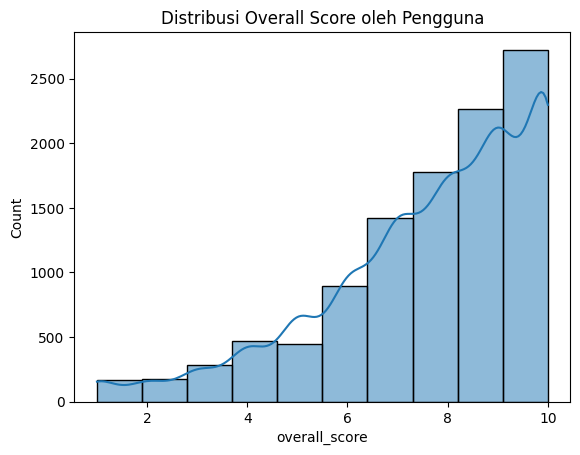

In [16]:
# Overall score distribution
sns.histplot(data=reviews_df, x='overall_score', bins=10, kde=True)
plt.title('Distribusi Overall Score oleh Pengguna')
plt.show()

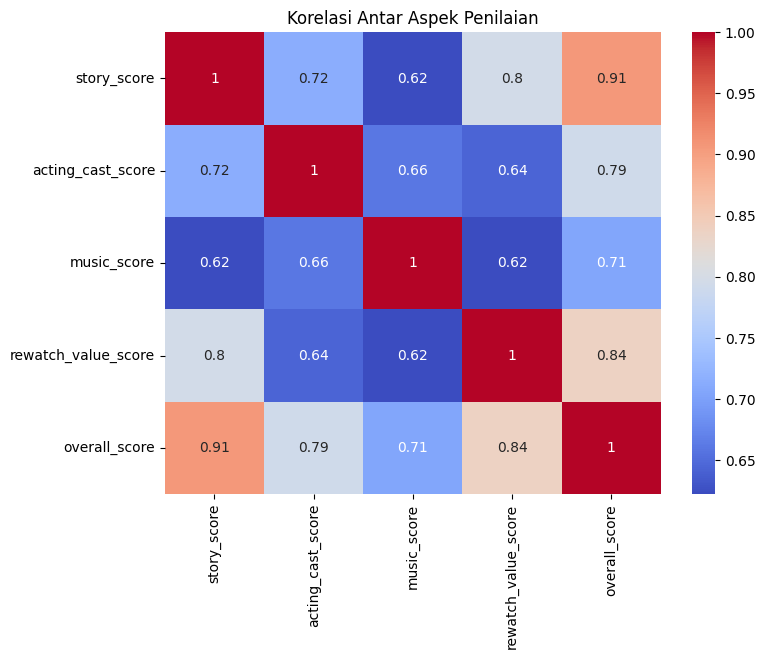

In [17]:
# Korelasi antar aspek penilaian
plt.figure(figsize=(8, 6))
sns.heatmap(reviews_df[['story_score', 'acting_cast_score', 'music_score', 'rewatch_value_score', 'overall_score']].corr(), annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Aspek Penilaian')
plt.show()

**Insight**


*   Ada kecenderungan yang kuat pengguna memberikan nilai positif atau baik untuk "overall score". Ini bisa berarti bahwa drama atau konten yang dinilai secara umum diterima dengan baik oleh pengguna. Ini karena dataset merupakan top 100 drama tertpopuler.
*   Korelasi antara overall_score dan story_score sangat tinggi (0.91). Ini menunjukkan bahwa kualitas cerita (story_score) adalah faktor paling dominan yang memengaruhi skor keseluruhan yang diberikan pengguna. Jika ceritanya bagus, kemungkinan besar skor keseluruhannya juga tinggi.
*   Korelasi antara overall_score dan rewatch_value_score juga sangat kuat (0.84). Ini menyiratkan bahwa nilai tonton ulang suatu drama juga merupakan prediktor yang kuat untuk skor keseluruhan. Jika drama layak ditonton ulang, itu cenderung mendapatkan skor keseluruhan yang tinggi.



## actors_df

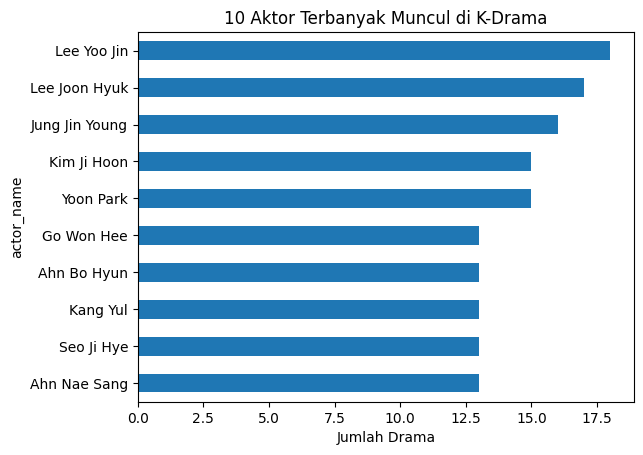

In [18]:
# Aktor dengan jumlah drama terbanyak
top_actors = actors_df['actor_name'].value_counts().head(10)
top_actors.plot(kind='barh')
plt.title('10 Aktor Terbanyak Muncul di K-Drama')
plt.xlabel('Jumlah Drama')
plt.gca().invert_yaxis()
plt.show()

**Insight**


*   Dominasi Lee Yoo Jin: Lee Yoo Jin adalah aktor yang paling sering muncul di K-Drama berdasarkan data ini, dengan jumlah kemunculan tertinggi (sekitar 18 drama). Ini menunjukkan popularitas dan kemungkinan produktivitasnya di industri K-Drama. Entah itu sebagai pemain utama, side, mamupun cameo
*   Konsistensi Penampilan: Keberadaan aktor-aktor ini dalam daftar menunjukkan konsistensi penampilan mereka dalam 100 drama terpopuler selama 2015-2023



# Data Preprocessing & Preparation

In [19]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

## Content-Based Filtering

In [48]:
# Bersihkan kolom list string
def clean_list_column(col):
    return col.apply(lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else [])

In [49]:
# Isi missing value dengan token pengganti agar tetap bisa diproses oleh TF-IDF
drama_df['director'] = drama_df['director'].fillna('no_director')
drama_df['screenwriter'] = drama_df['screenwriter'].fillna('no_screenwriter')
drama_df['synopsis'] = drama_df['synopsis'].fillna('no_synopsis')

# Hapus tanda kurung dan kutip dari kolom yang berbentuk string list
drama_df['director'] = drama_df['director'].str.replace(r"[\[\]']", '', regex=True)
drama_df['screenwriter'] = drama_df['screenwriter'].str.replace(r"[\[\]']", '', regex=True)

# Gabungkan beberapa kolom menjadi satu fitur teks gabungan
drama_df['combined_features'] = (
    drama_df['director'] + ' ' +
    drama_df['screenwriter'] + ' ' +
    drama_df['synopsis'] + ' ' +
    drama_df['content_rt']  # rating usia bisa berkontribusi
)

In [50]:
# Vectorize menggunakan TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(drama_df['combined_features'])

# Simpan index dan nama drama untuk pemetaan
drama_indices = pd.Series(drama_df.index, index=drama_df['drama_name']).drop_duplicates()

## Collaborative-based

In [29]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

In [30]:
# Gabungkan nama drama dari reviews_df dengan indeks di drama_df
collab_df = reviews_df[['user_id', 'title', 'overall_score']].copy()
collab_df = collab_df.merge(drama_df[['drama_name', 'kdrama_id']], left_on='title', right_on='drama_name', how='left')

In [31]:
# Drop missing ID
collab_df = collab_df.dropna(subset=['kdrama_id'])

# User-Item matrix
user_item_matrix = collab_df.pivot_table(index='user_id', columns='kdrama_id', values='overall_score')

# Isi nilai kosong dengan 0
user_item_matrix = user_item_matrix.fillna(0)


In [32]:
# Prepare data untuk surprise
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(collab_df[['user_id', 'drama_name', 'overall_score']], reader)

In [33]:
# SPLIT & TRAIN MODEL
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
model = SVD()
model.fit(trainset)

# Modelling

## Content-based Filtering

In [51]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [52]:
# Cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Index mapping
title_to_index = pd.Series(drama_df.index, index=drama_df['drama_name'].str.lower())

def recommend_drama(title, cosine_sim=cosine_sim, df=drama_df):
    title = title.lower()
    if title not in title_to_index:
        return "Drama not found in database."
    idx = title_to_index[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
    drama_indices = [i[0] for i in sim_scores]
    return df[['drama_name', 'year']].iloc[drama_indices]

In [53]:
# Contoh rekomendasi
recommend_drama("Weak Hero Class 1")

,drama_name,year
118,Somebody,2022
129,Bargain,2022
139,Yonder,2022
1447,The Miracle,2016
80,The Glory,2022
107,Recipe for Farewell,2022
121,Revenge of Others,2022
4,Celebrity,2023
264,The King of Pigs,2022
55,The Glory Part 2,2023


In [55]:
# Buat dictionary: user_id -> set drama yang disukai (overall_score >= 8), minimal 3 drama
user_relevant = reviews_df[reviews_df['overall_score'] >= 8].groupby('user_id')['title'].apply(set)
user_relevant = user_relevant[user_relevant.apply(len) >= 3].to_dict()

# Evaluation precision@K per user (K=10)
def precision_at_k(user_id, k=10):
    liked = user_relevant.get(user_id, set())
    if not liked:
        return None  # Lewati user tanpa data relevan

    # Ambil 1 drama yang disukai user untuk input content-based
    sample_title = list(liked)[0]

    # Dapatkan rekomendasi dari model content-based
    recs = recommend_drama(sample_title)
    if isinstance(recs, str):  # jika error seperti "Drama not found"
        return None

    recommended_titles = set(recs['drama_name'].values)
    relevant_and_recommended = liked & recommended_titles

    return len(relevant_and_recommended) / k

# Rata-rata precision
sample_users = list(user_relevant.keys())[:100]  # ambil 100 user pertama misalnya
precisions = [precision_at_k(u) for u in sample_users if precision_at_k(u) is not None]

avg_precision = sum(precisions) / len(precisions)
print(f"Average Precision@10: {avg_precision:.4f}")

Average Precision@10: 0.0110


**Insight**

1. **Rekomendasi mirip secara tema & atmosfer**
   Sistem merekomendasikan drama yang **memiliki kemiripan kuat dalam sutradara, penulis naskah, dan sinopsis**. Sebagai contoh, saat dimasukkan *"Weak Hero Class 1"*, drama yang direkomendasikan seperti *"Somebody"*, *"Bargain"*, *"The Glory"* memiliki **tone gelap, drama remaja-dewasa, dan konflik psikologis yang intens**, mencerminkan pendekatan konten yang konsisten.

2. **Akurat dalam menangkap semantik konten, tapi tidak personal**
   Karena model ini **tidak mempertimbangkan data interaksi pengguna**, rekomendasi yang diberikan sangat relevan terhadap konten, **namun belum tentu sesuai preferensi tiap user**.

3. **Rendahnya Precision\@10 (0.0110)** mengindikasikan:

   * Sebagian besar rekomendasi **tidak termasuk dalam daftar drama yang benar-benar disukai user berdasarkan skor ≥8**.
   * Ini menunjukkan bahwa **kemiripan konten saja tidak cukup** untuk memprediksi ketertarikan pengguna, apalagi jika selera mereka tidak konsisten dengan isi sinopsis atau kredensial kreator.

4. **Potensi peningkatan**:

   * **Penggabungan fitur lain** seperti genre atau jaringan TV berpotensi menambah konteks dan meningkatkan kualitas rekomendasi. Tetapi ini tidak ada di dataset
   * **Hybrid filtering** dapat membantu menangani kelemahan personalisasi di content-based filtering ini.

## Collaborative Filtering

In [38]:
from surprise.accuracy import rmse
import pandas as pd
from collections import Counter

In [39]:
# EVALUASI
predictions = model.test(testset)
rmse(predictions)

RMSE: 1.8451


1.8451493344713872

In [40]:
# REKOMENDASI UNTUK USER TERTENTU
def recommend_for_user(user_id, n=10):
    # Cari semua drama yang belum ditonton user
    watched = reviews_df[reviews_df['user_id'] == user_id]['title'].unique()
    all_titles = reviews_df['title'].unique()
    unwatched = [title for title in all_titles if title not in watched]

    # Prediksi rating untuk semua drama yang belum ditonton
    predictions = [model.predict(user_id, title) for title in unwatched]

    # Urutkan berdasarkan rating tertinggi
    top_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]

    # Kembalikan sebagai DataFrame
    return pd.DataFrame([{'title': p.iid, 'predicted_rating': p.est} for p in top_predictions])

In [41]:
# CONTOH
recommend_for_user('user_100')

,title,predicted_rating
0,My Mister,8.869208
1,Good Manager,8.837711
2,Six Flying Dragons,8.823583
3,Youth of May,8.814755
4,Awaken,8.754926
5,Children of Nobody,8.752513
6,Mr. Queen,8.750298
7,Crazy Love,8.728046
8,The Fiery Priest,8.724150
9,Our Blues,8.692143


In [42]:
recommended_titles = recommend_for_user('user_100')['title']
insight_df = drama_df[drama_df['drama_name'].isin(recommended_titles)]

# Hitung aktor/sutradara/genre yang paling sering muncul
from collections import Counter

actor_freq = Counter(','.join(insight_df['director'].dropna()).split(','))
screenwriter_freq = Counter(','.join(insight_df['screenwriter'].dropna()).split(','))
genre_freq = Counter(','.join(insight_df['content_rt'].dropna()).split(','))

print(actor_freq.most_common(5))
print(screenwriter_freq.most_common(5))
print(genre_freq.most_common(5))

[('Kim Kyu Tae', 1), (' Lee Jung Mook', 1), ('Kim Jung Hyun', 1), ('Song Min Yeop', 1), (' Lee Dae Kyung', 1)]
[('Park Jae Bum', 2), ('Noh Hee Kyung', 1), ('Kim Bo Gyeom', 1), ('Lee Kang', 1), ('Park Kye Ok', 1)]
[('15+ - Teens 15 or older', 10)]


In [43]:
# Dapatkan rekomendasi judul drama untuk user
recommended_titles = recommend_for_user('user_100')['title']
insight_df = drama_df[drama_df['drama_name'].isin(recommended_titles)]

# Pecah dan hitung frekuensi nama sutradara
director_freq = Counter(','.join(insight_df['director'].dropna()).split(','))

# Pecah dan hitung frekuensi nama screenwriter
screenwriter_freq = Counter(','.join(insight_df['screenwriter'].dropna()).split(','))

# Tampilkan 5 teratas
print("Top 5 Sutradara:")
print(director_freq.most_common(5))

print("\nTop 5 Screenwriter:")
print(screenwriter_freq.most_common(5))

Top 5 Sutradara:
[('Kim Kyu Tae', 1), (' Lee Jung Mook', 1), ('Kim Jung Hyun', 1), ('Song Min Yeop', 1), (' Lee Dae Kyung', 1)]

Top 5 Screenwriter:
[('Park Jae Bum', 2), ('Noh Hee Kyung', 1), ('Kim Bo Gyeom', 1), ('Lee Kang', 1), ('Park Kye Ok', 1)]


In [44]:
# Hitung distribusi rating konten dalam rekomendasi
content_rating_freq = insight_df['content_rt'].value_counts()

print("\nDistribusi Konten Rating dalam Rekomendasi:")
print(content_rating_freq)


Distribusi Konten Rating dalam Rekomendasi:
content_rt
15+ - Teens 15 or older    10
Name: count, dtype: int64


**Interpretasi**

* Root Mean Squared Error (RMSE) dari model collaborative filtering (menggunakan SVD) adalah 1.8451, menunjukkan bahwa rata-rata selisih prediksi rating dengan rating sebenarnya cukup moderat. Meskipun belum mencapai tingkat akurasi yang sangat tinggi, hasil ini masih dapat digunakan untuk memberikan rekomendasi yang relevan secara umum.
* Rekomendasi menunjukkan kecenderungan pada sutradara dengan gaya penyutradaraan yang realistis atau emosional, seringkali terlibat dalam drama bergenre slice of life atau romantic drama.
* Model menunjukkan kecenderungan merekomendasikan drama dengan rating remaja dan dewasa muda, yang umumnya mencakup tema percintaan, konflik keluarga, dan drama sosial.